# Visualize track result

In [65]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import json

def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()


#### Load track data

In [101]:
dataset = 'simulation_data'
scenario = '1-1'
#datafolder = 'simulation_20250305_160930' # set the folder name
datafolder = 'simulation_20250307_113704' # set the folder name
#datafolder = 'simulation_20250304_143046' # set the folder name
nsample = 100 # number of generated sample

path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk' 
obstacles = json.load(open(f"./data/{dataset}/Scenario{scenario}/obstacles.json"))
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load( f)


# samples: original predictions

all_target_np = all_target.cpu().numpy() # observed value (ground truth)
all_evalpoint_np = all_evalpoint.cpu().numpy() # target mask
all_observed_np = all_observed.cpu().numpy() # observed mask
all_given_np = all_observed_np - all_evalpoint_np # the mask for the given data (used for imputation)

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

In [102]:
gt_data = all_target_np
imputed_data = quantiles_imp[2] # 0.5 quantile(median of samples)
#imputed_data = samples.cpu().numpy()[:,99]
prediction_mask = all_observed_np[:,:,0] # observed mask
given_mask = all_given_np[:,:,0] # given mask

In [113]:
def visualize_data(gt_data, imputed_data, prediction_mask, given_mask, data_ind, obstacles=None):
    plt.figure(figsize=(12, 8))
    plt.rcParams["font.size"] = 16
    given_mask = given_mask[data_ind]
    prediction_mask = prediction_mask[data_ind]

    # Extract x and y coordinates (assumed to be the first two features)
    x_gt = gt_data[data_ind, :, 0]  # Ground truth X
    y_gt = gt_data[data_ind, :, 1]  # Ground truth Y

    x_obs = x_gt[given_mask == 1]  # Keep only observed X
    y_obs = y_gt[given_mask == 1]  # Keep only observed Y

    # Extract predicted (imputed) median
    x_pred = imputed_data[data_ind, :, 0]  # Predicted median X
    y_pred = imputed_data[data_ind, :, 1]  # Picted median Y

    #print(f"x_gt shape: {x_gt.shape}")
    #print(f"y_gt shape: {y_gt.shape}")
    #print(f"x_obs shape: {x_obs.shape}")
    #print(f"y_obs shape: {y_obs.shape}")
    #print(f"x_pred shape: {x_pred.shape}")
    #print(f"y_pred shape: {y_pred.shape}")
    # only keep the observed points
    x_gt = x_gt[prediction_mask == 1]
    y_gt = y_gt[prediction_mask == 1]
    x_pred = x_pred[prediction_mask == 1]
    y_pred = y_pred[prediction_mask == 1]
    print(f"x_gt shape: {x_gt.shape}")
    print(f"y_gt shape: {y_gt.shape}")
    print(f"x_pred shape: {x_pred.shape}")
    print(f"y_pred shape: {y_pred.shape}")

    ## Confidence Interval Bounds (5% and 95%)
    #x_lower = quantiles_imp[0][dataind, :, 0]
    #y_lower = quantiles_imp[0][dataind, :, 1]
    #x_upper = quantiles_imp[4][dataind, :, 0]
    #y_upper = quantiles_imp[4][dataind, :, 1]

    #x_lower = x_lower[observed_mask == 1]
    #y_lower = y_lower[observed_mask == 1]
    #x_upper = x_upper[observed_mask == 1]
    #y_upper = y_upper[observed_mask == 1]

    # Plot predicted (imputed) track
    plt.plot(x_pred, y_pred, color='g', linestyle='solid', label='Predicted Track (Median)')  # Median imputation
    #plt.fill_betweenx(y_pred, x_lower, x_upper, color='g', alpha=0.3, label='5-95% Confidence Region')  # Confidence interval

    # Plot Ground Truth for Missing Points (all ground truth, including missing ones)
    plt.scatter(x_gt, y_gt, color='b', marker='o', label='Ground Truth (Including Missing)')  

    # Plot Observed Points (now correctly filtered)
    plt.scatter(x_obs, y_obs, color='r', marker='x', label='Observed Points')

    # Track which labels have been added to the legend
    legend_entries = set()

    # Draw obstacles if provided
    if obstacles:
        for obstacle in obstacles:
            if "rectangle" in obstacle:
                rect = obstacle["rectangle"]
                x1, y1 = rect["p1"]
                x2, y2 = rect["p2"]
                label = "Obstacle (Rectangle)" if "rectangle" not in legend_entries else None
                plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='gray', alpha=0.5, label=label)
                legend_entries.add("rectangle")
            
            elif "standing_person" in obstacle:
                x, y = obstacle["standing_person"]
                label = "Standing Person" if "standing_person" not in legend_entries else None
                plt.scatter(x, y, color='black', marker='*', s=200, label=label)  # Star shape for person
                legend_entries.add("standing_person")

            elif "circle" in obstacle:
                circle_info = obstacle["circle"]
                center = circle_info["center"]
                radius = circle_info["radius"]
                label = "Obstacle (Circle)" if "circle" not in legend_entries else None
                circle = plt.Circle(center, radius, color='gray', alpha=0.5, label=label)
                plt.gca().add_patch(circle)
                legend_entries.add("circle")

            elif "wall" in obstacle:
                wall_points = obstacle["wall"]
                x_vals, y_vals = zip(*wall_points)  # Extract x and y coordinates
                label = "Wall" if "wall" not in legend_entries else None
                plt.plot(x_vals, y_vals, color='red', linestyle='-', linewidth=1, label=label)  # Thin red line
                legend_entries.add("wall")

            elif "entrance" in obstacle:
                entrance = obstacle["entrance"]
                x1, y1 = entrance["p1"]
                x2, y2 = entrance["p2"]
                label = "Entrance" if "entrance" not in legend_entries else None
                plt.plot([x1, x2], [y1, y2], color='blue', linestyle='-', linewidth=5, label=label)  # Thick blue line
                legend_entries.add("entrance")

    plt.xlim(0, 84)  # Set X-axis range
    plt.ylim(6, 20)  # Set Y-axis range
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("2D Track Imputation Visualization")
    plt.legend()
    plt.grid()
    plt.show()

x_gt shape: (120,)
y_gt shape: (120,)
x_pred shape: (120,)
y_pred shape: (120,)


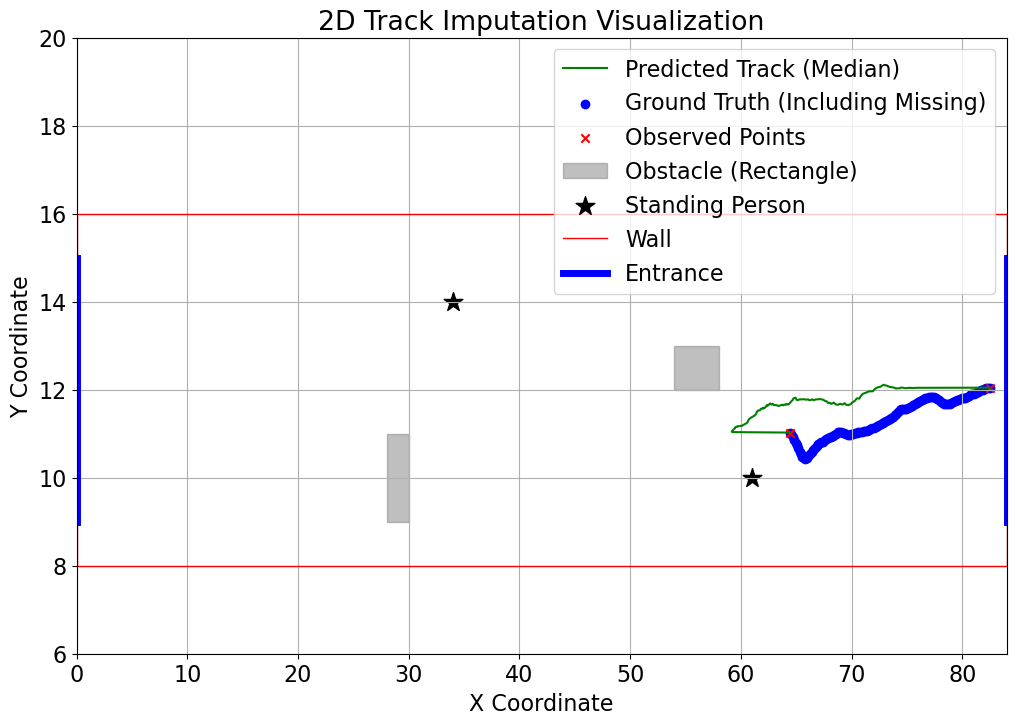

In [116]:
visualize_data(gt_data, imputed_data, prediction_mask, given_mask, 22,obstacles=obstacles)